<a href="https://colab.research.google.com/github/Dipolar-Quantum-Gases/nn-beam-profiling/blob/master/Explore_the_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Laser Beam Datasets

This notebook shows how to download and visualize the datasets from the the paper "Measuring Laser Beams with a Neural Network."

See the ArXiv and [published versions](https://doi.org/10.1364/AO.443531) for more information.

##Downloading and extacting the datasets

The class below is used to download a .zip file from a url string to the zip_dir. The downloaded .zip is then extracted to unzip_dir.

In [1]:
import os
import subprocess
from pathlib import Path

class dataset_extractor():

  def __init__(self, dataset, url_string, zip_dir, unzip_dir):
    zip_path = zip_dir / (dataset + '.zip')

    self.make_local_data_dir(zip_dir)
    self.download_zip(str(zip_path), url_string)
    self.make_local_data_dir(unzip_dir)
    self.unpack_zip(str(zip_path), str(unzip_dir))


  def make_local_data_dir(self, local_data_path):
      if not os.path.isdir(local_data_path):
        os.makedirs(local_data_path)


  def download_zip(self, zip_path, url_string):
    result = subprocess.run(['wget', '-O', zip_path, url_string])


  def unpack_zip(self, zip_path, unzip_path):
    result = subprocess.run(['unzip', str(zip_path), '-d', str(unzip_path)])

Our paper includes [two datasets](https://ora.ox.ac.uk/objects/uuid:e7f9ee4c-5b07-469f-979c-73b8a28d7ec2). One for simulated laser beams and one for experimental laser beams. The simulated datasets is ~7GB and takes a long time to download. We recommend visualizing the experimental dataset initially.

In [2]:
#the .zip urls of the two datasets
dataset_urls = {'experimental_data': "https://ora.ox.ac.uk/objects/uuid:e7f9ee4c-5b07-469f-979c-73b8a28d7ec2/download_file?safe_filename=experimental_data.zip&type_of_work=Dataset",
                'simulation_data': "https://ora.ox.ac.uk/objects/uuid:e7f9ee4c-5b07-469f-979c-73b8a28d7ec2/download_file?safe_filename=simulation_data.zip&type_of_work=Dataset"}

zip_dir = Path('/content/data/datasets/compressed_data')
unzip_dir = Path('/content/data/datasets')
dataset = 'experimental_data'
# dataset = 'simulation_data'
dataset_extractor(dataset, dataset_urls[dataset], zip_dir, unzip_dir)

The dataset contains a directory for the .tiff images in greyscale as well as these same images mapped to RGB .png images using the Viridis colormap.

Lastly, the dataset contains a text directory with all the labels/annotations for the images. These are included in a two .json files. One for the training data and one for the validation data.

We load these using Pandas and display the training annotation dataframe below.

In [3]:
import pandas as pd

def get_paths(dataset, local_data_path):
  dataset_path = local_data_path /  dataset
  text_path = dataset_path / 'text'
  img_path = dataset_path / 'imgs'
  return dataset_path, text_path, img_path

dataset_path, text_path, img_path = get_paths(dataset, unzip_dir)
train_df = pd.read_json(text_path / 'data_train.json')
validation_df = pd.read_json(text_path / 'data_val.json')
train_df

,run,num_beams,label,rgb_paths,gray_paths,fits,lab_radii,scale_radii,width,height,bbox_1,abox_1,keypoint_1,mask_1,bbox_1.5,abox_1.5,keypoint_1.5,mask_1.5,bbox_2,abox_2,keypoint_2,mask_2
0,1250,1,[1],\imgs\1250.png,\fimgs\1250.tiff,"[[37.5486549313, 118.2391443286, 114.263298271...","[[7.9078664716, 14.9067212667]]","[1, 1.5, 2]",256,256,"[[110.331277857, 99.3565770045, 126.1470108002...","[[118.2391443286, 114.2632982712, 29.964748092...","[[[118.2391443286, 114.2632982712, 1.0], [119....","[{'size': [256, 256], 'counts': ']ck06f79H6L3M...","[[106.3773446212, 91.9032163711, 130.100944036...","[[118.2391443286, 114.2632982712, 44.947122138...","[[[118.2391443286, 114.2632982712, 1.0], [120....","[{'size': [256, 256], 'counts': '\cj06d7<G7J5K...","[[102.4234113854, 84.4498557378, 134.054877271...","[[118.2391443286, 114.2632982712, 59.929496185...","[[[118.2391443286, 114.2632982712, 1.0], [121....","[{'size': [256, 256], 'counts': '[ci05c7`0D9I5..."
1,1305,1,[1],\imgs\1305.png,\fimgs\1305.tiff,"[[97.192581614, 178.6669327683, 114.9096192981...","[[8.3479124033, 8.8090122945]]","[1, 1.5, 2]",256,256,"[[170.319020365, 106.1006070036, 187.014845171...","[[178.6669327683, 114.9096192981, 18.523232538...","[[[178.6669327683, 114.9096192981, 1.0], [184....","[{'size': [256, 256], 'counts': 'bcZ14j75K3N2N...","[[166.1450641634, 101.6961008564, 191.18880137...","[[178.6669327683, 114.9096192981, 27.784848807...","[[[178.6669327683, 114.9096192981, 1.0], [186....","[{'size': [256, 256], 'counts': 'bcY16g76K3N2M...","[[161.9711079617, 97.2915947092, 195.362757574...","[[178.6669327683, 114.9096192981, 37.046465076...","[[[178.6669327683, 114.9096192981, 1.0], [189....","[{'size': [256, 256], 'counts': 'acX19d76K3M4M..."
2,284,1,[1],\imgs\284.png,\fimgs\284.tiff,"[[88.1595417324, 75.5897780712, 143.524599882,...","[[10.238919479, 7.824842465]]","[1, 1.5, 2]",256,256,"[[65.3508585922, 135.699757417, 85.8286975502,...","[[75.5897780712, 143.524599882, 20.6091620558,...","[[[75.5897780712, 143.524599882, 1.0], [85.743...","[{'size': [256, 256], 'counts': ']\`03k74M3M2O...","[[60.2313988527, 131.7873361846, 90.9481572897...","[[75.5897780712, 143.524599882, 30.9137430837,...","[[[75.5897780712, 143.524599882, 1.0], [90.819...","[{'size': [256, 256], 'counts': '\T?5i74L4M2O1...","[[55.1119391132, 127.8749149521, 96.0676170292...","[[75.5897780712, 143.524599882, 41.2183241116,...","[[[75.5897780712, 143.524599882, 1.0], [95.896...","[{'size': [256, 256], 'counts': '[l=6g76L2N3M2..."
3,22,1,[1],\imgs\22.png,\fimgs\22.tiff,"[[81.9876905184, 152.6337410083, 145.245440954...","[[8.6858049432, 8.964713]]","[1, 1.5, 2]",256,256,"[[143.9479360651, 136.2807279545, 161.31954595...","[[152.6337410083, 145.2454409545, 19.226334264...","[[[152.6337410083, 145.2454409545, 1.0], [158....","[{'size': [256, 256], 'counts': '`TT16h74L3N1O...","[[139.6050335935, 131.7983714545, 165.66244842...","[[152.6337410083, 145.2454409545, 28.839501397...","[[[152.6337410083, 145.2454409545, 1.0], [161....","[{'size': [256, 256], 'counts': '_TS19d75M2N2M...","[[135.2621311219, 127.3160149546, 170.00535089...","[[152.6337410083, 145.2454409545, 38.452668529...","[[[152.6337410083, 145.2454409545, 1.0], [165....","[{'size': [256, 256], 'counts': 'blQ15g78I5M2M..."
4,804,1,[1],\imgs\804.png,\fimgs\804.tiff,"[[24.2963276656, 82.0208392464, 108.9222025798...","[[17.8236117181, 10.1354833934]]","[1, 1.5, 2]",256,256,"[[64.1972275283, 98.7867191864, 99.8444509645,...","[[82.0208392464, 108.9222025798, 38.0951207704...","[[[82.0208392464, 108.9222025798, 1.0], [99.60...","[{'size': [256, 256], 'counts': 'aS`03l73L2O2N...","[[55.2854216693, 93.7189774897, 108.7562568235...","[[82.0208392464, 108.9222025798, 57.1426811556...","[[[82.0208392464, 108.9222025798, 1.0], [108.3...","[{'size': [256, 256], 'counts': 'dk=4j73M3N2N1...","[[46.3736158102, 88.651235793, 117.6680626826,...","[[82.0208392464, 108.9222025798, 76.1902415408...","[[[82.0208392464, 108.9222025798, 1.0], [117.1...",

##Visualizing the dataset

This class is used to convert the annotations (which are saved in the Detectron2 format) to a form which can be plotted using Matplotlib.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class box_plotting():

    def convert_detectron_abox(self, x0, y0, dx, dy, theta):
        theta = theta * (-np.pi / 180)
        return x0, y0, dx / 2 , dy / 2, theta


    def bbox_from_fit(self, x0, y0, wx, wy, scale=1):
        xmin = x0 - wx * scale
        ymin = y0 - wy * scale
        xmax = x0 + wx * scale
        ymax = y0 + wy * scale
        bbox = [xmin, ymin, xmax, ymax]
        return bbox

    
    def get_bbox_plot_data(self, xmin, ymin, xmax, ymax):
        xdata = np.array([xmin, xmax, xmax, xmin, xmin])
        ydata = np.array([ymax, ymax, ymin, ymin, ymax])
        return xdata, ydata
    
    
    def get_abox_plot_data(self, x0, y0, wx, wy, theta, scale=1):
        x0, y0, wx, wy, theta = self.convert_detectron_abox(x0, y0, wx, wy, theta)
        bbox = self.bbox_from_fit(x0, y0, wx, wy, scale)
        xdata, ydata = self.get_bbox_plot_data(*bbox)
        rot_xdata, rot_ydata = self.rotate_coordinates(-theta, x0, y0, xdata, ydata)
        return rot_xdata, rot_ydata
    

    def rotate_coordinates(self, theta, x0, y0, X, Y):
        img_shape = X.shape
        coords = np.stack([X - x0, Y - y0])
        R = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])
        Xr, Yr = R.dot(coords)
        return Xr + x0, Yr + y0

    def lab_widths(self, wx, wy, theta):
        wxx = ((wx * np.cos(theta))** 2 + 
                            (wy * np.sin(theta))**2)**.5
        wyy = ((wx * np.sin(theta))** 2 + 
                            (wy * np.cos(theta))**2)**.5
        return wxx, wyy


    def plot_abox(self, ax, abox):
      xdata, ydata = self.get_abox_plot_data(*abox)
      ax.plot(xdata[1:], ydata[1:], color='white')
      ax.plot(xdata[:2], ydata[:2], color='white', linestyle='--')

bp = box_plotting()

###Rotated regions-of-interest

Below we randomly select images in the training dataset and visualize both the image and the rotated-regions-of-interest around the laser beams. These are used to train the Rotated Region Propsals Network in the paper.

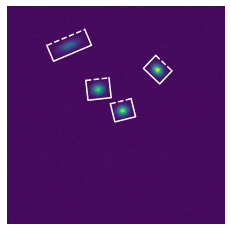

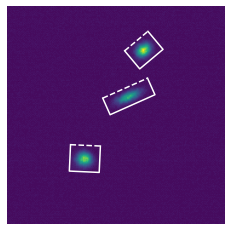

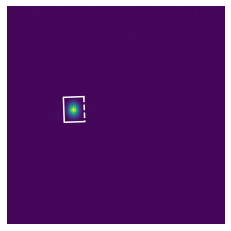

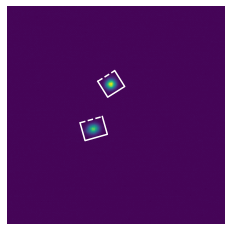

In [5]:
from PIL import Image

for d in np.random.randint(len(train_df), size=4): 
  row = train_df.iloc[d]
  rgb_path = row['rgb_paths'].replace('\\', '/')
  img_data = np.array(Image.open(str(dataset_path) + rgb_path))

  aboxes = row['abox_1.5']

  fig, ax1 = plt.subplots()
  ax1.set_axis_off()
  ax1.imshow(img_data, origin='lower')
  for abox in aboxes:
    bp.plot_abox(ax1, abox)

###Regions-of-interest

Alternatively if we want to train a general object detection neural network like Faster-RCNN or YOLOv3 we can get the non-rotated bounding boxes.

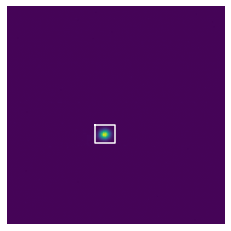

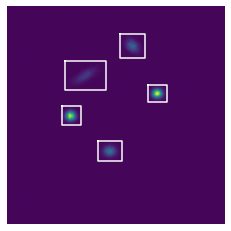

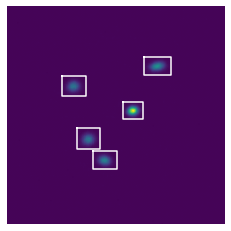

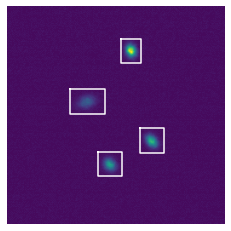

In [6]:
for d in np.random.randint(len(train_df), size=4): 
  row = train_df.iloc[d]
  rgb_path = row['rgb_paths'].replace('\\', '/')
  img_data = np.array(Image.open(str(dataset_path) + rgb_path))

  bboxes = row['bbox_1.5']

  fig, ax1 = plt.subplots()
  ax1.imshow(img_data, origin='lower')
  ax1.set_axis_off()
  for bbox in bboxes:
    xdata, ydata = bp.get_bbox_plot_data(*bbox)
    ax1.plot(xdata, ydata, color='white')

###Segmentation Masks

Training a Mask-RCNN requires us to provide segmentation masks as well which are saved as RLE bitmasks. These need to be converted to Numpy arrays to be useful.

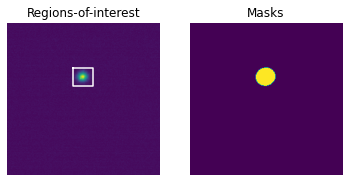

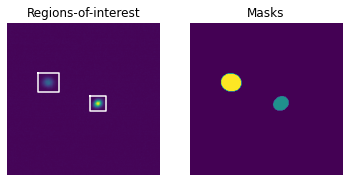

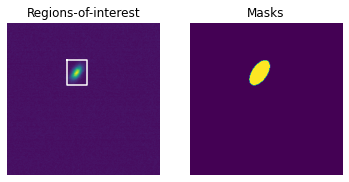

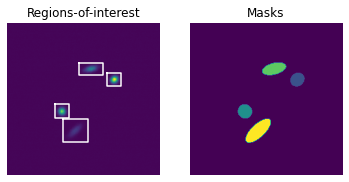

In [7]:
from pycocotools import mask as Mask

def combine_masks(masks):
  total_mask = np.zeros(masks[0].shape)
  for index, mask in enumerate(masks):  
    total_mask[mask] = index + 1
  return total_mask

for d in np.random.randint(len(train_df), size=4): 
  row = train_df.iloc[d]
  rgb_path = row['rgb_paths'].replace('\\', '/')
  img_data = np.array(Image.open(str(dataset_path) + rgb_path))
  
  bboxes = row['bbox_1.5']
  bit_masks = row['mask_1.5']
  masks = [np.ndarray.astype(Mask.decode(mask), dtype=bool) for mask in bit_masks]
  total_mask = combine_masks(masks) #combine masks into single numpy array for plotting

  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.set_axis_off()
  ax2.set_axis_off()
  ax1.imshow(img_data, origin='lower')
  ax2.imshow(total_mask, origin='lower')
  ax1.set_title('Regions-of-interest')
  ax2.set_title('Masks')
  for bbox, mask in zip(bboxes, masks):
    xdata, ydata = bp.get_bbox_plot_data(*bbox)
    ax1.plot(xdata, ydata, color='white')


###Varying boundary definitions

For the above examples the ROIs, RROIs and masks are all defined at the laser beams' 1.5x 1/e^2 radii. However, the dataset also contains annotations for 1x and 2x the 1/e^2 radii. These can potentially be useful as a hyperparameter when training neural networks. Below we should the different annotations for a single image

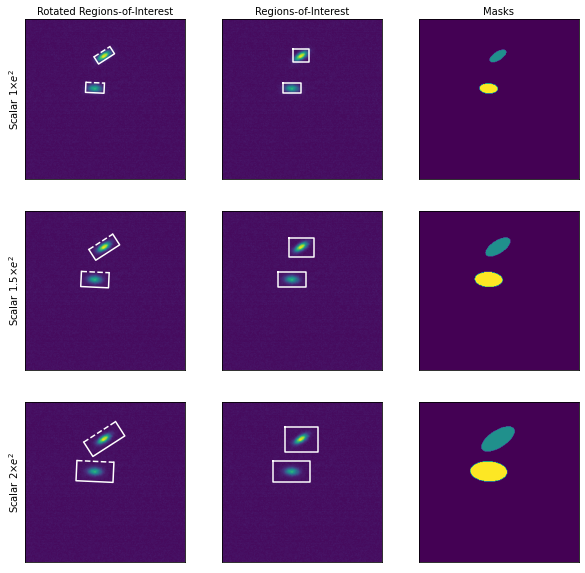

In [8]:
for d in np.random.randint(len(train_df), size=1): 
  row = train_df.iloc[d]
  rgb_path = row['rgb_paths'].replace('\\', '/')
  img_data = np.array(Image.open(str(dataset_path) + rgb_path))
  
  xlabels = ['Rotated Regions-of-Interest','Regions-of-Interest','Masks']
  fig, axs = plt.subplots(3, 3, figsize=(10,10))
  [ax.xaxis.set_label_position('top') for ax in axs[0]]
  [ax.set_xlabel(label) for ax, label in zip(axs[0], xlabels)]

  scale_radii = row['scale_radii']
  for scalar, raxs in zip(scale_radii, axs):
    aboxes = row['abox_' + str(scalar)]
    bboxes = row['bbox_' + str(scalar)]
    bit_masks = row['mask_' + str(scalar)]
    masks = [np.ndarray.astype(Mask.decode(mask), dtype=bool) for mask in bit_masks]
    total_mask = combine_masks(masks)

    [ax.set_xticks([]) for ax in raxs]
    [ax.set_yticks([]) for ax in raxs]

    (ax1, ax2, ax3) = raxs
    ax1.imshow(img_data, origin='lower')
    ax2.imshow(img_data, origin='lower')
    ax3.imshow(total_mask, origin='lower')
    ax1.set_ylabel('Scalar ' + str(scalar) + r'$\times e^2$')

    for abox, bbox, mask in zip(aboxes, bboxes, masks):
      bp.plot_abox(ax1, abox)
      xdata, ydata = bp.get_bbox_plot_data(*bbox)
      ax2.plot(xdata, ydata, color='white')
  

###2D Gaussian fits

The annotations above are all calculated using the 2D Gaussian parameters for each beam. For the simulation dataset these are randomly chosen, whereas for the experimental data they were found using an iterative 2D fit process. Below we show a comparison of the experimental data and simulated images created using the fit parameters.

First we make a class to simulate an image given a list of 2D Gaussian beam parameters.

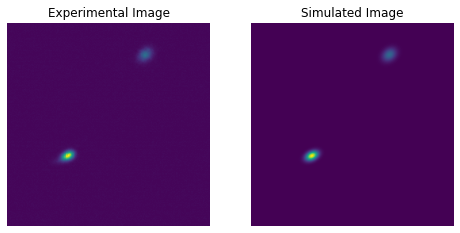

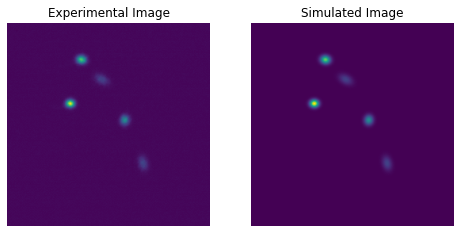

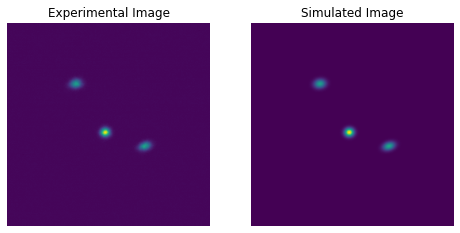

In [12]:
class simulate_image():

  def twoDGaussian(self, xy_coords, i0, x0, y0, wx, wy, theta):
      """The rotated elliptical 2D Gaussian function for fitting    
      Args:
          xy_tuple: tuple containing two 1D numpy arrays with x and y coords
          i0, x0, y0, wx, wy, offset, theta: 2D Gaussian parameters
      Returns:
          intensity: 1D numpy array with 2D Gaussian distribution
      """        
      X, Y = xy_coords
  #    theta = theta - np.pi /2
      a = np.cos(theta)**2 / (wx**2) + np.sin(theta)**2 /(wy**2)
      b = -np.sin(2 * theta) / (wy**2) + np.sin(2 * theta)/(wx**2)
      c = np.sin(theta)**2 / (wx**2) + np.cos(theta)**2 / (wy**2)
      
      gamma = a * (X - x0)**2 + b * (X - x0) * (Y - y0) + c * (Y - y0)**2
      intensity = i0 * np.exp(- 2 * gamma)
      
      return intensity


  def multi_gaussian(self, xy_tuple, offset, *args):
      # print(len(args), args)
      X, Y = xy_tuple
      num_gaussians = len(args) // 6
      intensity = offset * np.ones(X.shape)
      for i in range(0, num_gaussians):
          start = i * 6 
          end = (i + 1) * 6
          parameters = args[start:end]
          intensity += self.twoDGaussian(xy_tuple, *parameters)
      return intensity


  def get_coordinates(self, width, height):
      """
      Gets image coordinates in Detectron2 definition (offset by 0.5)
      """
      x = np.linspace(.5, width - .5, width) 
      y = np.linspace(.5, height - .5, height)
      return np.meshgrid(x, y)


  def get_multi_gaussian_args(self, fits):
      """
      Converts list of 2D Gaussian fits for individual beams into a single
      offset and a single list with the remaining Gaussian parameters
      """
      fit_params = [fit[:-1] for fit in fits]
      fit_params = [item for sublist in fit_params for item in sublist]
      offset = np.mean([fit[-1] for fit in fits])
      return fit_params, offset


  def get_simulation_image(self, width, height, fits):
      xy_coords = self.get_coordinates(width, height)
      fit_params, offset = self.get_multi_gaussian_args(fits)
      simulation_image = self.multi_gaussian(xy_coords, offset, *fit_params)
      return simulation_image
      
simg = simulate_image()

Next we compare the experimental image data to one of these images simulated using the fit parameters. Note this will only work for the experimental dataset. The simulation dataset

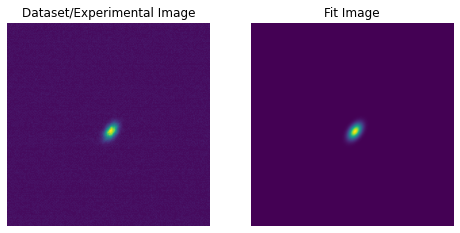

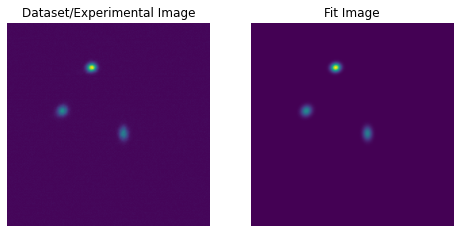

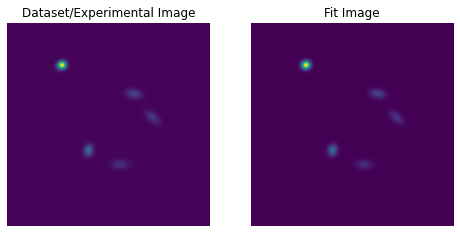

In [13]:
for d in np.random.randint(len(train_df), size=3): 
  row = train_df.iloc[d]
  rgb_path = row['rgb_paths'].replace('\\', '/')
  img_data = np.array(Image.open(str(dataset_path) + rgb_path))

  width, height = img_data.shape[:2]
  fits = row['fits']
  fit_image = simg.get_simulation_image(width, height, fits)

  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
  ax1.set_axis_off()
  ax2.set_axis_off()
  ax1.set_title('Dataset/Experimental Image')
  ax1.imshow(img_data, origin='lower')
  ax2.set_title('Fit Image')
  ax2.imshow(fit_image, origin='lower')